In [1]:
import os

import numpy as np
import tensorflow as tf
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
train_filepath = os.path.join('.', 'data', 'mental_health_train.csv')
eval_filepath = os.path.join('.', 'data', 'mental_health_eval.csv')
holdout_filepath = os.path.join('.', 'data', 'mental_health_holdout.csv')

In [3]:
def dataset_input_fn(filepath, batch_size=32, shuffle_buffer_size=None, repeat=False):
    def input_fn():
        field_names = ['bmi', 'sleep_time', 'physical_health_days', 'diabetes_age', 'mental_health_days']
        field_defaults = [[-1], [-1], [-1], [-1], [-1]]

        def _parse(line):
            """Parse example from the BRFSS csv file."""
            
            decoded_line = tf.decode_csv(line, field_defaults)
            
            features = dict(zip(field_names, decoded_line))
            for name in field_names:
                features[name] = tf.to_int32(features.pop(name))
            
            label = features.pop('mental_health_days')
            
            return features, label

        ds = tf.data.TextLineDataset(filepath).skip(1)
        ds = ds.map(_parse)
        if shuffle_buffer_size is not None:
            ds = ds.shuffle(shuffle_buffer_size)
        ds = ds.batch(batch_size)
        if repeat:
            ds = ds.repeat()

        iterator = ds.make_one_shot_iterator()

        features, label = iterator.get_next()
        return features, label
    return input_fn

In [4]:
sleep_time = tf.feature_column.numeric_column('sleep_time')
bmi = tf.feature_column.numeric_column('bmi')
physical_health = tf.feature_column.numeric_column('physical_health_days')
diabetes_age = tf.feature_column.numeric_column('diabetes_age')

feature_columns = [bmi, sleep_time, physical_health, diabetes_age]

In [5]:
estimator = tf.estimator.LinearRegressor(feature_columns=feature_columns, model_dir='./model')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001F4C298B7F0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [6]:
def train(steps=5000, shuffle_buffer_size=32000):
    estimator.train(dataset_input_fn(train_filepath, shuffle_buffer_size=32000, repeat=True), steps=steps)
    
def evaluate():
    estimator.evaluate(dataset_input_fn(eval_filepath))
    
def predict():
    predictions = estimator.predict(dataset_input_fn(holdout_filepath))
    predictions = list(predictions)
    predictions = pd.DataFrame([{'prediction': x['predictions'][0]} for x in predictions])
    
    actual = pd.read_csv(holdout_filepath, dtype={'mental_health_days': np.int32})
    return actual.join(predictions)

def graph_predictions(df, num=100):
    df.loc[:, ['mental_health_days', 'prediction']].head(num).reset_index().drop('index', axis=1).plot(kind='line')
    plt.savefig('predictions.png')

def error_stats(predictions):
    predictions['error'] = abs(predictions.mental_health_days - predictions.prediction)
    return (predictions.error.mean(), predictions.error.std(), predictions.error.var())
    

In [7]:
train()
evaluate()

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into ./model\model.ckpt.
INFO:tensorflow:loss = 10870.0, step = 1
INFO:tensorflow:global_step/sec: 674.203
INFO:tensorflow:loss = 3299.205, step = 101 (0.149 sec)
INFO:tensorflow:global_step/sec: 1467.38
INFO:tensorflow:loss = 3677.1152, step = 201 (0.068 sec)
INFO:tensorflow:global_step/sec: 395.759
INFO:tensorflow:loss = 3203.6138, step = 301 (0.267 sec)
INFO:tensorflow:global_step/sec: 1449.93
INFO:tensorflow:loss = 3026.5566, step = 401 (0.054 sec)
INFO:tensorflow:global_step/sec: 1882.66
INFO:tensorflow:loss = 3303.7212, step = 501 (0.053 sec)
INFO:tensorflow:global_step/sec: 417.257
INFO:tensorflow:loss = 3626.4106, step = 601 (0.239 sec)
INFO:tensorflow:global_step/sec: 1809
INFO:tensorflow:loss = 3248.606

In [8]:
predictions = predict()

mean, std, var = error_stats(predictions)
print('Mean: %f, Std: %f, Var: %f' % (mean, std, var))
predictions.head()

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model\model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Mean: 10.066905, Std: 9.638168, Var: 92.894289


,bmi,sleep_time,physical_health_days,diabetes_age,mental_health_days,prediction,error
0,2720,8,30,54,30,20.377176,9.622824
1,2976,4,15,55,20,13.956879,6.043121
2,3052,6,2,40,4,8.386441,4.386441
3,3260,7,15,35,4,14.382919,10.382919
4,3138,8,3,42,10,9.230395,0.769605


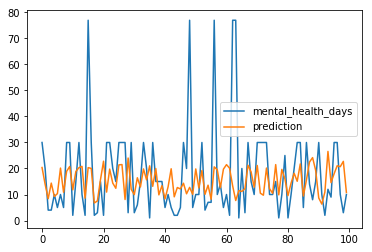

In [9]:
graph_predictions(predictions)